In [2]:
import json
import joblib
import pickle
import pandas as pd
import numpy as np
# import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [61]:
train = pd.read_csv('data/train.csv')
# transforming Date column in datetime
train['Date']=pd.to_datetime(train['Date'], infer_datetime_format=True)

# auxiliar Date feature (for temporal analyzis)
train['referencia'] = train['Date'].dt.year*100 + train['Date'].dt.month

In [60]:
# train = pd.read_csv('data/train.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660611 entries, 0 to 660610
Data columns (total 16 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   observation_id                            660611 non-null  object 
 1   Type                                      660611 non-null  object 
 2   Date                                      660611 non-null  object 
 3   Part of a policing operation              507047 non-null  object 
 4   Latitude                                  548295 non-null  float64
 5   Longitude                                 548295 non-null  float64
 6   Gender                                    660611 non-null  object 
 7   Age range                                 660611 non-null  object 
 8   Self-defined ethnicity                    655037 non-null  object 
 9   Officer-defined ethnicity                 660611 non-null  object 
 10  Legislation         

In [4]:
# TYPE

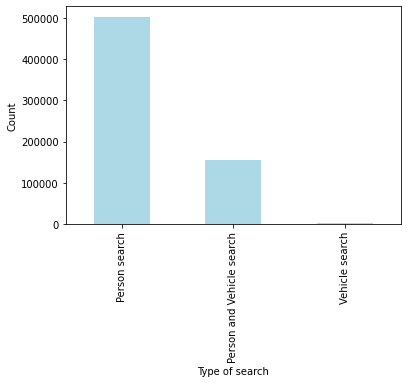

In [28]:
# plt.figure(figsize=(4,4));
train['Type'].value_counts(dropna=False).plot(kind='bar',color='lightblue');
plt.xlabel('Type of search');
plt.ylabel('Count');

In [9]:
# DATE 

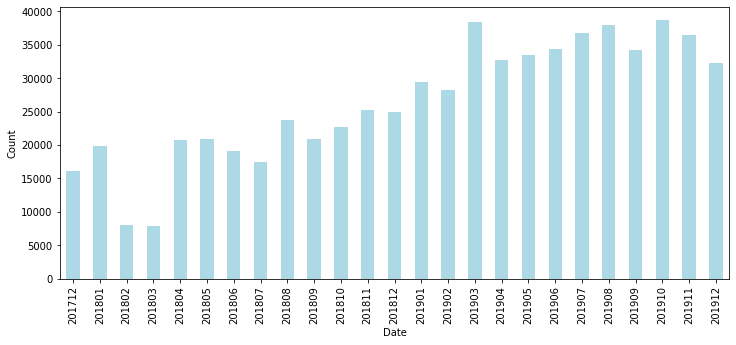

In [29]:
plt.figure(figsize=(12,5));
train['referencia'].value_counts(dropna=False).sort_index().plot(kind='bar',color='lightblue');
plt.xlabel('Date');
plt.ylabel('Count');

In [ ]:
#Part of a policing operation

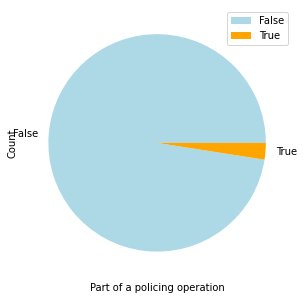

In [58]:
plt.figure(figsize=(12,5));
train['Part of a policing operation'].fillna(False).value_counts(dropna=False).plot(kind='pie',colors=['lightblue','orange']);
plt.xlabel('Part of a policing operation');
plt.ylabel('Count');
plt.legend();

In [ ]:
#Gender

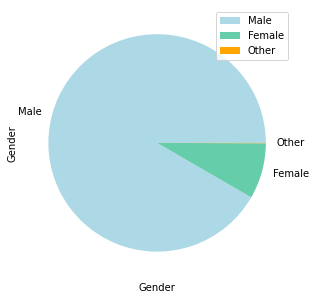

In [44]:
plt.figure(figsize=(12,5));
train['Gender'].fillna(False).value_counts(dropna=False).plot(kind='pie',colors=['lightblue','mediumaquamarine','orange']);
plt.xlabel('Gender');
plt.legend();

In [112]:
train['Gender'].fillna(False).value_counts(dropna=False)

Male      605422
Female     54812
Other        377
Name: Gender, dtype: int64

In [ ]:
#Age range

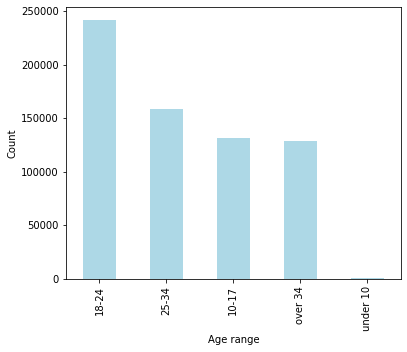

In [32]:
plt.figure(figsize=(6,5));
train['Age range'].value_counts(dropna=False).plot(kind='bar',color='lightblue');
plt.xlabel('Age range');
plt.ylabel('Count');

In [ ]:
#Officer-defined ethnicity

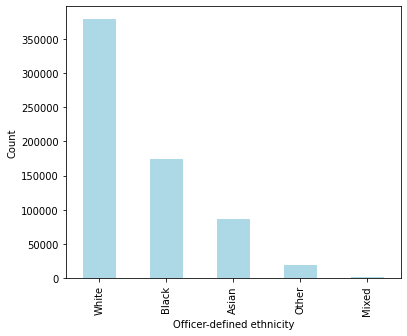

In [33]:
plt.figure(figsize=(6,5));
    train['Officer-defined ethnicity'].value_counts(dropna=False).plot(kind='bar',color='lightblue');
plt.xlabel('Officer-defined ethnicity');
plt.ylabel('Count');

In [52]:
#Self-defined ethnicity

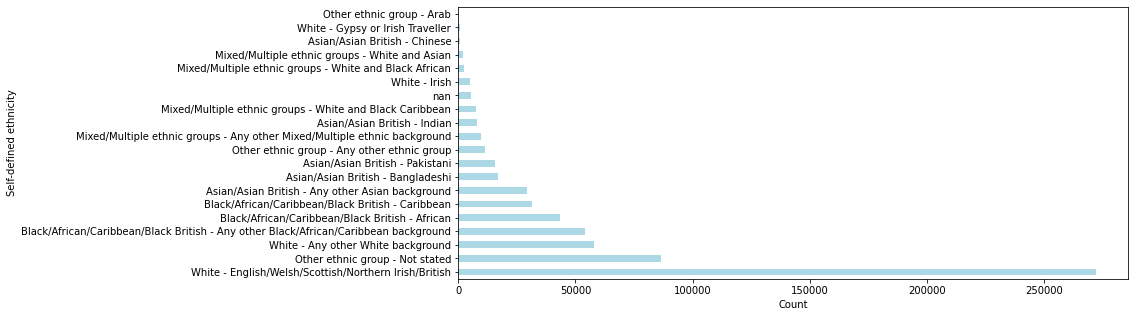

In [34]:
plt.figure(figsize=(12,5));
train['Self-defined ethnicity'].value_counts(dropna=False).plot(kind='barh',color='lightblue');
plt.xlabel('Count');
plt.ylabel('Self-defined ethnicity');

In [62]:
#Legislation

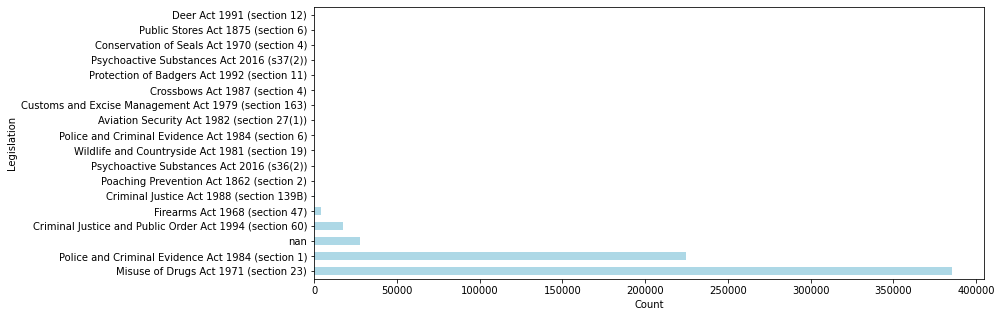

In [35]:
plt.figure(figsize=(12,5));
train['Legislation'].value_counts(dropna=False).plot(kind='barh',color='lightblue');
plt.xlabel('Count');
plt.ylabel('Legislation');

In [ ]:
#Object of search

Controlled drugs                              398873
Offensive weapons                             102107
Stolen goods                                   67636
Article for use in theft                       30836
Evidence of offences under the Act             19911
Anything to threaten or harm anyone            19762
Articles for use in criminal damage            11060
Firearms                                        5479
Fireworks                                       2948
Psychoactive substances                         1701
Detailed object of search unavailable            129
Game or poaching equipment                       102
Evidence of wildlife offences                     25
Goods on which duty has not been paid etc.        23
Crossbows                                         17
Seals or hunting equipment                         2
Name: Object of search, dtype: int64


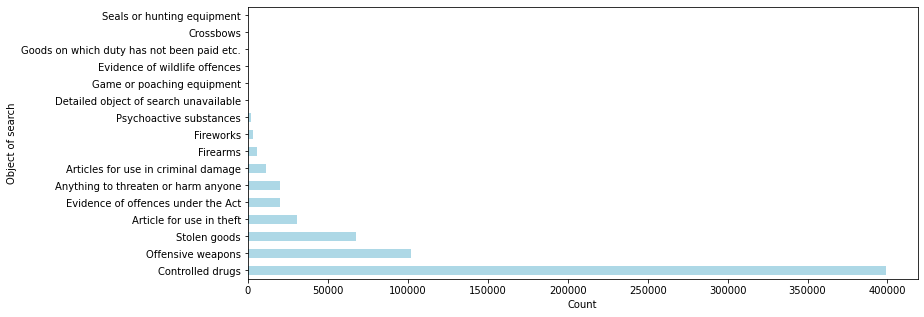

In [36]:
print(train['Object of search'].value_counts(dropna=False))
plt.figure(figsize=(12,5));
train['Object of search'].value_counts(dropna=False).plot(kind='barh',color='lightblue');
plt.xlabel('Count');
plt.ylabel('Object of search');

In [ ]:
#Outcome

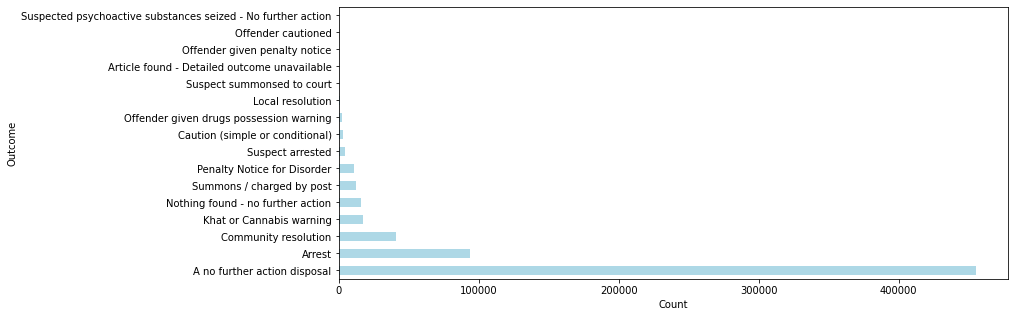

In [27]:
plt.figure(figsize=(12,5));
train['Outcome'].value_counts(dropna=False).plot(kind='barh',color='lightblue');
plt.xlabel('Count');
plt.ylabel('Outcome');

In [ ]:
#Outcome linked to object of search

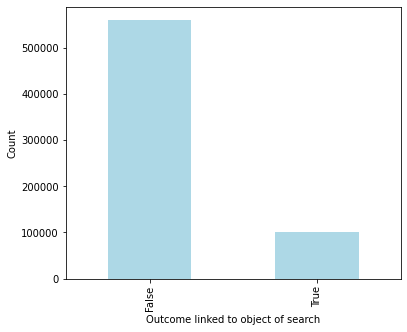

In [37]:
plt.figure(figsize=(6,5));
train['Outcome linked to object of search'].fillna(False).value_counts(dropna=False).plot(kind='bar',color='lightblue');
plt.ylabel('Count');
plt.xlabel('Outcome linked to object of search');

<Figure size 864x360 with 0 Axes>

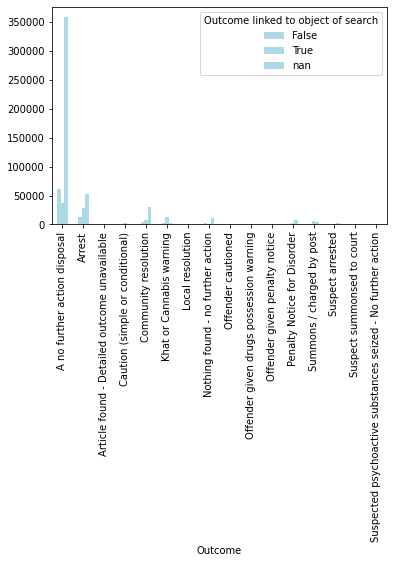

In [53]:
plt.figure(figsize=(12,5));
train.groupby(['Outcome','Outcome linked to object of search'], dropna=False)['Outcome'].count().unstack().plot(kind = 'bar',color='lightblue');


In [79]:
#Removal of more than just outer clothing

In [18]:
mask= ((train['Type']!='Vehicle search') & 
      (train['Removal of more than just outer clothing'] != True) &
      (train['Removal of more than just outer clothing'] != False))

train.loc[mask, 'Removal of more than just outer clothing']=False

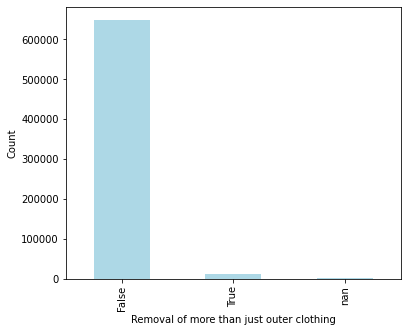

In [38]:
plt.figure(figsize=(6,5));
train['Removal of more than just outer clothing'].value_counts(dropna=False).plot(kind='bar',color='lightblue');
plt.ylabel('Count');
plt.xlabel('Removal of more than just outer clothing');

In [ ]:
#station

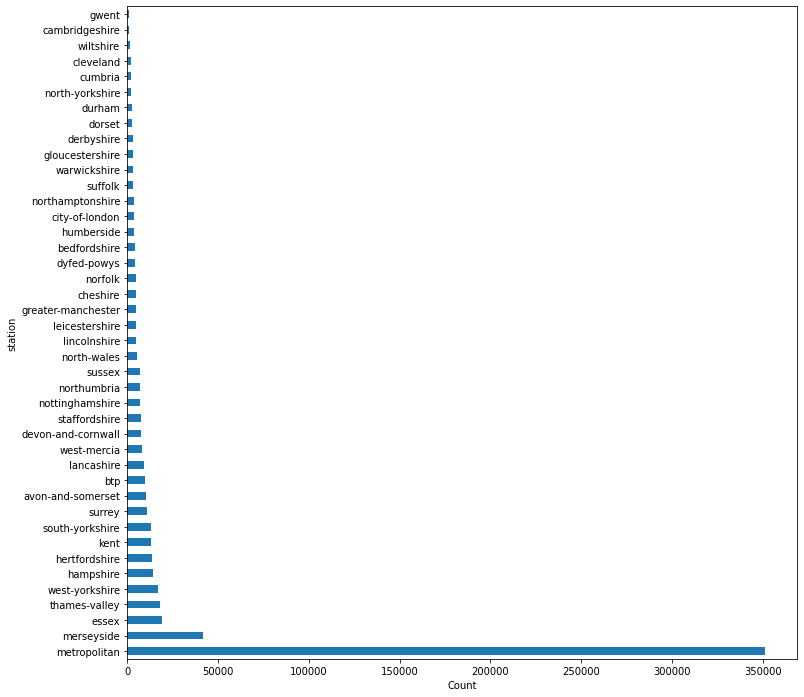

In [83]:
plt.figure(figsize=(12,12));
train['station'].value_counts(dropna=False).plot(kind='barh');
plt.xlabel('Count');
plt.ylabel('station');

In [ ]:
#target variables

In [97]:
train.groupby(['station','Outcome linked to object of search'], dropna=False)['Outcome'].count().unstack()

Outcome linked to object of search,False,True,NaN
station,,,
avon-and-somerset,643.0,2869.0,6503.0
bedfordshire,242.0,816.0,3151.0
btp,1429.0,8121.0,5.0
cambridgeshire,138.0,180.0,559.0
cheshire,591.0,1353.0,2901.0
city-of-london,2250.0,1236.0,89.0
cleveland,105.0,478.0,1289.0
cumbria,801.0,1224.0,104.0
derbyshire,229.0,2623.0,NaN


In [104]:
train.groupby(['station','Removal of more than just outer clothing'], dropna=False)['Outcome'].count().unstack()

Removal of more than just outer clothing,False,True,NaN
station,,,
avon-and-somerset,9384.0,631.0,NaN
bedfordshire,4143.0,54.0,12.0
btp,9526.0,29.0,NaN
cambridgeshire,855.0,22.0,NaN
cheshire,4636.0,209.0,NaN
city-of-london,3452.0,123.0,NaN
cleveland,1870.0,NaN,2.0
cumbria,1978.0,146.0,5.0
derbyshire,2626.0,226.0,NaN


In [105]:
train.groupby(['station','Gender'], dropna=False)['Outcome'].count().unstack()

Gender,Female,Male,Other
station,,,
avon-and-somerset,1336.0,8679.0,NaN
bedfordshire,379.0,3825.0,5.0
btp,703.0,8849.0,3.0
cambridgeshire,137.0,739.0,1.0
cheshire,429.0,4416.0,NaN
city-of-london,354.0,3218.0,3.0
cleveland,175.0,1697.0,NaN
cumbria,303.0,1825.0,1.0
derbyshire,279.0,2572.0,1.0


In [106]:
train.groupby(['station','Officer-defined ethnicity'], dropna=False)['Outcome'].count().unstack()

Officer-defined ethnicity,Asian,Black,Mixed,Other,White
station,,,,,
avon-and-somerset,288.0,1468.0,428.0,143.0,7688.0
bedfordshire,974.0,832.0,2.0,59.0,2342.0
btp,757.0,2931.0,NaN,177.0,5690.0
cambridgeshire,67.0,106.0,NaN,23.0,681.0
cheshire,101.0,151.0,NaN,19.0,4574.0
city-of-london,753.0,792.0,NaN,135.0,1895.0
cleveland,111.0,50.0,NaN,24.0,1687.0
cumbria,35.0,24.0,NaN,9.0,2061.0
derbyshire,315.0,281.0,NaN,44.0,2212.0


In [109]:
train.groupby(['station','Age range'], dropna=False)['Outcome'].count().unstack()

Age range,10-17,18-24,25-34,over 34,under 10
station,,,,,
avon-and-somerset,1738.0,3125.0,2530.0,2614.0,8.0
bedfordshire,1043.0,1686.0,832.0,641.0,7.0
btp,2309.0,3417.0,2046.0,1758.0,25.0
cambridgeshire,212.0,299.0,187.0,176.0,3.0
cheshire,834.0,1540.0,1171.0,1300.0,NaN
city-of-london,260.0,1341.0,1205.0,769.0,NaN
cleveland,223.0,424.0,541.0,684.0,NaN
cumbria,356.0,608.0,569.0,594.0,2.0
derbyshire,507.0,978.0,738.0,628.0,1.0


In [110]:
train.groupby(['Removal of more than just outer clothing','Age range'], dropna=False)['Outcome'].count().unstack()

Age range,10-17,18-24,25-34,over 34,under 10
Removal of more than just outer clothing,,,,,
False,130724.0,237426.0,154873.0,125650.0,372.0
True,955.0,4063.0,3025.0,2610.0,12.0
NaN,84.0,416.0,283.0,118.0,NaN


In [111]:
train.groupby(['Removal of more than just outer clothing','Officer-defined ethnicity'], dropna=False)['Outcome'].count().unstack()

Officer-defined ethnicity,Asian,Black,Mixed,Other,White
Removal of more than just outer clothing,,,,,
False,84834,171943,1719,19597,370952
True,977,2313,110,209,7056
NaN,224,337,1,36,303
